### Подключение некоторых библиотек

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузим данные и удалим лишние признаки:

In [2]:
features = pd.read_csv('features.csv', index_col='match_id').drop(["duration",
                                                                   "tower_status_radiant","tower_status_dire", 
                                                                   "barracks_status_radiant", "barracks_status_dire"], axis = 1)

### Определим количество и место пропусков в данных:

In [3]:
np.sum(features.isnull(), axis =0)

start_time                         0
lobby_type                         0
r1_hero                            0
r1_level                           0
r1_xp                              0
r1_gold                            0
r1_lh                              0
r1_kills                           0
r1_deaths                          0
r1_items                           0
r2_hero                            0
r2_level                           0
r2_xp                              0
r2_gold                            0
r2_lh                              0
r2_kills                           0
r2_deaths                          0
r2_items                           0
r3_hero                            0
r3_level                           0
r3_xp                              0
r3_gold                            0
r3_lh                              0
r3_kills                           0
r3_deaths                          0
r3_items                           0
r4_hero                            0
r

Из полученых данных видно, что пропусков нет в признаках, связанных с описаниями персонажей игроков. 
Пропуски присутствуют в следующих признаках (группах признаков):
* Признаки события "первая кровь" (first blood) -- Могут отсутствовать так как данное событие не произошло в первые 5 минут
     * first_blood_time
     * first_blood_team
     * first_blood_player1
     * first_blood_player2
* Признаки для каждой команды -- Все эти признаки также связаны с событиями (покупки и использование предметов), которые могли и не произойти
    * radiant\_(dire\_)bottle_time
    * radiant\_(dire\_)courier_time
    * radiant\_(dire\_)flying_courier_time
    * radiant\_(dire\_)first_ward_time
 

In [4]:
features = features.fillna(0)

In [5]:
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,35,103,-84,221,3,4,2,2,-52,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,-20,149,-84,195,5,4,3,1,-5,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,-39,45,-77,221,3,4,3,1,13,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,-30,124,-80,184,0,4,2,0,27,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,46,182,-80,225,6,3,3,0,-16,0


Целевая переменная содержится в столбце **radiant_win**. 

Отделим данный столбец от основных данных

In [6]:
y = features["radiant_win"]
X = features.drop("radiant_win", axis =1)

Как видно, модель с 30 деревьями на кросс-валидации обучается ~1 минуту 26 секунд (на моем компьютере). При увеличении числа деревьев можно попробовать каждое новое дерево обучать на новой случайной подвыборке объектов и признаков.

# Подход 2: логистическая регрессия

### Проведем масштабирование признаков для лучшей работы алгоритма

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Импортируем необходимые библиотеки

In [16]:
from  sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

### Сoздадим модель логистической регрессии и будем подбирать на кросс-валидации параметр С из набора Сs

In [17]:
cs = np.arange(1, 50, 0.5)
lr = LogisticRegressionCV(Cs = cs, penalty = "l2", cv = kfold, scoring = "roc_auc")

### Проведем обучение модели и подбор гиперпараметра:

In [18]:
%%time
lr.fit(X_scaled,y)

Wall time: 1min 3s


LogisticRegressionCV(Cs=array([  1. ,   1.5, ...,  49. ,  49.5]),
           class_weight=None,
           cv=sklearn.cross_validation.KFold(n=97230, n_folds=5, shuffle=True, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

Мы можем видеть, что на обучение 100 моделей с различными значениями гиперпараметра на кросс-валидации из прошлого подхода ушло 1 мин 3 секунды. Обучение одной модели логистической занимает меньше времени чем обучение одной модели градиентного бустинга с 30 деревьями.

Построим график качества модели для различных параметров С и выведем значение С, при котором качество было наилучшим.

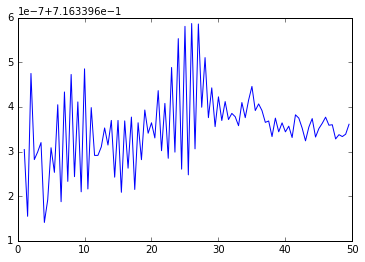

In [19]:
pylab.plot(lr.Cs_,lr.scores_[1].mean(axis=0))

In [20]:
lr.C_[0]

26.0

### Для найденой лучшей модели посчитаем ее качество

In [21]:
roc_auc_score(y,lr.predict_proba(X_scaled)[:,1])

0.71798979818768405

Видно, что качество логистической регрессии получилось даже лучше чем при градиентном бустинге с 30 деревьями. Однако, это может быть связано с недостаточной сложностью модели градиентного бустинга.

### Разделим выборку на категориальные и вещественные признаки

In [22]:
cat = ["lobby_type", "r1_hero", "r2_hero", "r3_hero","r4_hero", "r5_hero", "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"]

In [23]:
X_cat = X[cat]
X_num = scaler.fit_transform(X.drop(cat,axis = 1))

### Обучим логистическую регрессию только на вещественных признаках

In [24]:
cs = np.arange(1, 50, 0.5)
lr = LogisticRegressionCV(Cs = cs, penalty = "l2", cv = kfold, scoring = "roc_auc")

In [25]:
%%time
lr.fit(X_num,y)

Wall time: 1min 5s


LogisticRegressionCV(Cs=array([  1. ,   1.5, ...,  49. ,  49.5]),
           class_weight=None,
           cv=sklearn.cross_validation.KFold(n=97230, n_folds=5, shuffle=True, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

### Построим график качества модели для различных параметров С и выведем значение С, при котором качество было наилучшим.

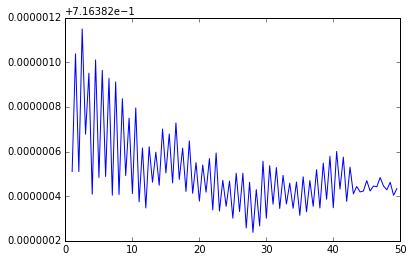

In [26]:
pylab.plot(lr.Cs_,lr.scores_[1].mean(axis=0))

In [27]:
lr.C_[0]

2.5

### Для найденой лучшей модели посчитаем ее качество

In [28]:
roc_auc_score(y,lr.predict_proba(X_num)[:,1])

0.71784671810946032

Можно видеть, что качество незначительно уменьшилось (изменеие знблюдается в 4 знаке). Это могло произойти потому, что веса при категориальных признаках до удаления были достаточно малы чтобы не оказывать существенного влияния на результат, однако при их удалении мы все же потеряли некотрую информацию.

### Сформирем "мешок слов" по героям

Для этого обратимся к данным обо всех героях **heroes.csv**

In [29]:
heroes = pd.read_csv("heroes.csv")
heroes.head()

,id,localized_name,name
0,1,Anti-Mage,antimage
1,2,Axe,axe
2,3,Bane,bane
3,4,Bloodseeker,bloodseeker
4,5,Crystal Maiden,crystal_maiden


Таким образом, общее число героев соответствует максимальному **id** или длине списка. Выполним преобразование.

In [30]:
N = heroes.shape[0]
N

112

Всего в игре существует 112 героев

In [32]:
X_pick = np.zeros((X_cat.shape[0], N))

for i, match_id in enumerate(X_cat.index):
    for p in range(5):
        X_pick[i, X_cat.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_cat.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [33]:
X_f = np.hstack([X_num,X_pick])

### Как и в предыдущих 2 пунктах, обучим логистическую регрессию, построим график, найдем оптимальное значение С.

In [34]:
cs = np.arange(0.5, 50, 0.5)
lr = LogisticRegressionCV(Cs = cs, penalty = "l2", cv = kfold, scoring = "roc_auc")

In [35]:
%%time
lr.fit(X_f,y)

Wall time: 1min 54s


LogisticRegressionCV(Cs=array([  0.5,   1. , ...,  49. ,  49.5]),
           class_weight=None,
           cv=sklearn.cross_validation.KFold(n=97230, n_folds=5, shuffle=True, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

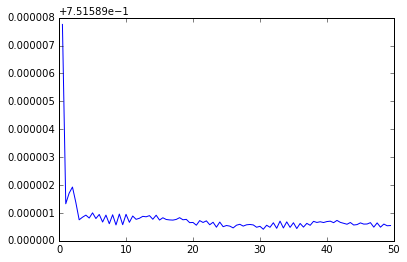

In [36]:
pylab.plot(lr.Cs_,lr.scores_[1].mean(axis=0))

In [37]:
lr.C_[0]

0.5

### Посчитаем качество для лучшей модели

In [38]:
roc_auc_score(y,lr.predict_proba(X_f)[:,1])

0.7544500974006314

Видно, что качество сильно улучшилось по сравнению со всеми предыдущими моделями. Это связано с добавлением новых сущесвенных признаков, влияющих на результат кластеризации.

# Применим итоговую модель к тестовой выборке

In [40]:
test = pd.read_csv("features_test.csv", index_col='match_id').fillna(0)
test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12,247,-86,272,3,4,2,0,118
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29,168,-54,0,3,2,2,1,16
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22,46,-87,186,1,3,3,0,-34
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49,30,-89,210,3,4,2,1,-26
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36,180,-86,180,1,3,2,1,-33


In [41]:
test_num = scaler.transform(test.drop(cat,axis = 1))
test_cat = test[cat]

In [42]:
test_pick = np.zeros((test_cat.shape[0], N))

for i, match_id in enumerate(test_cat.index):
    for p in range(5):
        test_pick[i, test_cat.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        test_pick[i, test_cat.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [43]:
prob = lr.predict_proba(np.hstack([test_num,test_pick]))[:,1]

In [44]:
(np.max(prob), np.min(prob))

(0.99642434668145041, 0.0084542402422104219)